Open Questions

- https://en.wikipedia.org/wiki/FASTA_format#Sequence_representation, non-actg rep?
- dealing w varying lengths - fundamental cnn problem
- trimming sequences, must find minimum among all, should they be recentered?
    - padding instead of truncate 
- variation of sequences - not all dengue? maintaining an equal split?

In [5]:
!source ../../env/bin/activate

In [6]:
import pandas as pd
from Bio import SeqIO # FASTA reader
import numpy as np 

def find_min_length(fasta_sequences):
    seq_lengths = []

    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        seq_lengths.append(len(sequence))

    return min(seq_lengths)

ModuleNotFoundError: No module named 'pandas'

In [15]:
def one_hot_encode(seq):
    # https://en.wikipedia.org/wiki/FASTA_format#Sequence_representation
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'b':[0,0,0,0], 'v':[0,0,0,0], 'n':[0,0,0,0], 'd':[0,0,0,0], 'm':[0,0,0,0], 'h':[0,0,0,0], 'w':[0,0,0,0], 'y':[0,0,0,0], 's':[0,0,0,0], 'r':[0,0,0,0], 'k':[0,0,0,0]}
    return [ltrdict[x] for x in seq]

def get_data(fasta_sequences):
    min_len = 9083 # in the dengue_fasta
    sequences = []
    for i, fasta in enumerate(fasta_sequences):
        if i == 300:
            break
        name, sequence = fasta.id, str(fasta.seq)
        one_hot_sequence = one_hot_encode(sequence.lower())
        if (len(one_hot_sequence) >= min_len):
            one_hot_sequence = one_hot_sequence[0: (min_len-1)]
        sequences.append(one_hot_sequence)
    return np.asarray(sequences)

In [16]:
file = "/Users/alevenberg/research/VirLab/src/cnn/genomes/aedes/dengue.fasta"
filetype = "fasta"
aedes_fasta_sequences = list(SeqIO.parse(file, filetype))

aedes_data = get_data(aedes_fasta_sequences)
print(aedes_data.shape)
aedes_labels = np.ones(300)
print(aedes_labels.shape)

(300, 9082, 4)
(300,)


In [17]:
file = "/Users/alevenberg/research/VirLab/src/cnn/genomes/culex/japanese-encephalitis.fasta"
filetype = "fasta"
culex_fasta_sequences = list(SeqIO.parse(file, filetype))

min_len = find_min_length(culex_fasta_sequences)
culex_data = get_data(culex_fasta_sequences)
print(culex_data.shape)
culex_labels = np.zeros(300)
print(culex_labels.shape)

(300, 9082, 4)
(300,)


In [18]:
# combine data

data = np.concatenate((aedes_data, culex_data))
labels = np.concatenate((aedes_labels, culex_labels))

In [ ]:
from torch.utils.data import Dataset, DataLoader

class VirLabDataset(Dataset):
    """ VirLabDataset dataset."""

    # Initialize your data, download, etc.
    def __init__(self, data, labels):
        self.len = data.shape[0]
        self.x_data = data
        self.y_data = labels

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
    
dataset = VirLabDataset(data, labels)
train_loader = DataLoader(dataset=dataset,
                          batch_size=30,
                          shuffle=True,
                          num_workers=2)

In [ ]:
# To view data 
# batch = next(iter(train_loader)) 
# seqs, labels = batch
# print(labels[0])

In [28]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x)

model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            
for epoch in range(1, 10):
    train(epoch)


NameError: name 'Variable' is not defined

In [112]:
# To delete rows
aedes_data = np.delete(aedes_data, range(366, 6403) ,axis = 0)
print(aedes_data.shape)

(366, 9083, 4)


In [9]:
np.array(aedes_sequences).shape

(6403,)

In [11]:
file = "/Users/alevenberg/research/VirLab/src/cnn/genomes/aedes/dengue.fasta"
filetype = "fasta"
aedes_fasta_sequences = list(SeqIO.parse(file, filetype))

min_len = find_min_length(fasta_sequences)
aedes_data = get_data(fasta_sequences, min_len)
print(aedes_data.shape)

(300, 9083, 4)


In [87]:
b = []
a = [[1, 0, 0, 0], [0, 1, 0, 0]]
b.append(a)
b.append(a)
print(b)
print(type(a))

np.asarray(b).shape

[[[1, 0, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [0, 1, 0, 0]]]
<class 'list'>


(2, 2, 4)

In [10]:
np.array(culex_sequences).shape

(366,)

In [4]:
file = "/Users/alevenberg/research/VirLab/src/cnn/genomes/aedes/dengue.fasta"
filetype = "fasta"
fasta_sequences = list(SeqIO.parse(file, filetype))

aedes_sequences = []
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    one_hot_sequence = one_hot_encode(sequence.lower())
    aedes_sequences.append(np.array(one_hot_sequence))

print(aedes_sequences[0])

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


In [ ]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int, n_values=5)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

In [3]:
import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
# from Bio import SeqIO # FASTA reader
import numpy as np 

file = "/Users/alevenberg/research/VirLab/results/4-4mers in Test_Aedes and Test_Culex.csv"

data = pd.read_csv(file) 

In [66]:
import pandas as pd
from Bio import SeqIO
import numpy as np
import time 

def one_hot_encode(seq):
    # https://en.wikipedia.org/wiki/FASTA_format#Sequence_representation
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'b':[0,0,0,0], 'v':[0,0,0,0], 'n':[0,0,0,0], 'd':[0,0,0,0], 'm':[0,0,0,0], 'h':[0,0,0,0], 'w':[0,0,0,0], 'y':[0,0,0,0], 's':[0,0,0,0], 'r':[0,0,0,0], 'k':[0,0,0,0]}
    return [ltrdict[x] for x in seq]

filetype = "fasta"

In [103]:
import statistics 

file = "/Users/alevenberg/research/VirLab/src/cnn/genomes/culex/japanese-encephalitis.fasta"
# fasta_sequences = list(SeqIO.parse(file, filetype))

seq_lengths = []
# MAX_LENGTH = 10296
MAX_LENGTH = 10296
BASES = 4

# culex_sequences = np.array([]).reshape(0, MAX_LENGTH, BASES)
culex_sequences = []
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    one_hot_sequence = one_hot_encode(sequence.lower())
    seq_lengths.append(len(sequence))
    if (len(one_hot_sequence) >= MAX_LENGTH):
        one_hot_sequence = one_hot_sequence[0: (MAX_LENGTH-1)]
#     print(np.array(one_hot_sequence).shape)
#     np.stack((culex_sequences, (np.array(one_hot_sequence))))
#     np.concatenate((culex_sequences,(np.array(one_hot_sequence))),axis=0)
    culex_sequences.append(one_hot_sequence)

# print("Minimum length: ", min(seq_lengths))
# print("Maximum length: ", max(seq_lengths))
# print("Avg length: ", statistics.mean(seq_lengths))

b = np.asarray(culex_sequences)
# print(b[0:2])
print(b.shape)

# b = b.reshape(len(b), len(b[0]), len(b[0][0])) 
# print(b.shape)
# M = np.stack(culex_sequences)
# M.shape 
# print()
# == (10,5,4,2,5,1,2)# b = np.array(culex_sequences)
# print
# b = b.reshape(len(b), len(b[0]), len(b[0][0])) 

(366, 10295, 4)


In [2]:
vectors = data["VECTORS"] # 256 kmers
data.head()

,VECTORS,Test_Culex,Test_Culex.1,Test_Aedes,Test_Culex.2,Test_Culex.3,Test_Culex.4,Test_Culex.5,Test_Aedes.1,Test_Aedes.2,...,Test_Aedes.206,Test_Culex.191,Test_Culex.192,Test_Aedes.207,Test_Culex.193,Test_Aedes.208,Test_Culex.194,Test_Culex.195,Test_Aedes.209,Test_Aedes.210
0,AAAA,865.682522,511.247444,699.936369,1017.811705,668.002672,668.002672,0.000000,492.610837,1252.609603,...,778.354337,1017.811705,668.002672,1237.113402,1017.811705,1258.232576,865.761414,1333.333333,3030.30303,0.0
1,AAAC,492.072171,613.496933,445.414053,763.358779,668.002672,668.002672,609.756098,985.221675,695.894224,...,416.975537,763.358779,668.002672,687.285223,763.358779,658.606114,492.117014,222.222222,1010.10101,0.0
2,AAAG,783.670494,613.496933,699.936369,763.358779,467.601870,467.601870,0.000000,492.610837,974.251914,...,787.620460,763.358779,467.601870,962.199313,763.358779,1091.123562,783.741912,888.888889,4040.40404,0.0
3,AAAT,400.947695,204.498978,390.873557,254.452926,534.402138,534.402138,304.878049,985.221675,1113.430759,...,250.185322,254.452926,534.402138,1099.656357,254.452926,619.286346,410.097512,1111.111111,0.00000,0.0
4,AACA,601.421542,408.997955,599.945460,1017.811705,668.002672,668.002672,304.878049,492.610837,1461.377871,...,583.765752,1017.811705,601.202405,1443.298969,1017.811705,992.824142,601.476351,444.444444,2020.20202,0.0


In [3]:
culex = []
first_column = data["Test_Culex"].to_numpy()
culex.append(first_column)
for i in range(1,196):
    column = data["Test_Culex." + str(i)].to_numpy()
    culex.append(column)

culex = np.array(culex)
print(culex.shape) 

(196, 256)


In [4]:
aedes = []
first_column = data["Test_Aedes"].to_numpy()
aedes.append(first_column)
for i in range(1,211):
    column = data["Test_Aedes." + str(i)].to_numpy()
    aedes.append(column)

aedes = np.array(aedes)
print(aedes.shape) 

(211, 256)


- Note: some are really sparse and idk why? (lots of 0's)
- Also some of them have different # of sequences 
- Originally aedes has 211 seq and culex has 196
    - Gonna trim to 196

In [5]:
# Trim aedes 
aedes = aedes[0:196]
aedes.shape

(196, 256)

In [6]:
# Make labels
aedes_labels = np.zeros(aedes.shape[0]) 
culex_labels = np.ones(culex.shape[0]) 

aedes_labels.shape # Shape: (196,)
culex_labels.shape # Shape: (196,)

(196,)

In [7]:
#IMPORT DATASET
training_file = "/Users/alevenberg/research/VirLab/results/training_sig_k_mers.csv"
testing_file = "/Users/alevenberg/research/VirLab/results/testing_sig_k_mers.csv"

train_dataset = pd.read_csv(training_file)
test_dataset = pd.read_csv(testing_file)

In [8]:
train_dataset.head()

,TTTT,TTTG,TTTA,TTTC,TTGT,TTGG,TTGC,TTAC,TTCT,TTGA,...,TGTT,TGTG,TGTC,TCTT,TGGC,TCCG,TGGG,TCTA,TGTA,Class
0,337.160561,437.397485,173.136504,264.260980,264.260980,738.108256,291.598323,227.811190,273.373428,419.172590,...,291.598323,592.309094,318.935666,309.823219,765.445599,182.248952,719.883361,145.799162,154.911609,1
1,306.748466,511.247444,0.000000,511.247444,306.748466,1022.494888,204.498978,102.249489,511.247444,613.496933,...,408.997955,715.746421,306.748466,204.498978,1022.494888,0.000000,715.746421,0.000000,204.498978,1
2,254.522316,527.224798,90.900827,327.242978,436.323971,809.017362,336.333061,163.621489,445.414053,663.576039,...,418.143805,709.026452,499.954550,454.504136,854.467776,181.801654,763.566948,145.441324,181.801654,0
3,254.452926,254.452926,0.000000,254.452926,254.452926,763.358779,254.452926,254.452926,254.452926,508.905852,...,0.000000,508.905852,254.452926,508.905852,254.452926,0.000000,1017.811705,0.000000,254.452926,1
4,467.601870,467.601870,400.801603,334.001336,267.201069,868.403474,66.800267,334.001336,534.402138,534.402138,...,334.001336,467.601870,467.601870,534.402138,668.002672,133.600534,868.403474,133.600534,267.201069,1


In [9]:
test_dataset.head()

,TTTT,TTTG,TTTA,TTTC,TTGT,TTGG,TTGC,TTAC,TTCT,TTGA,...,TGTT,TGTG,TGTC,TCTT,TGGC,TCCG,TGGG,TCTA,TGTA,Class
0,3738.317757,0.000000,0.000000,2803.738318,0.000000,0.000000,0.000000,0.0,934.579439,0.000000,...,0.000000,0.000000,0.000000,2803.738318,934.579439,0.0,0.000000,0.0,0.000000,0
1,934.579439,934.579439,0.000000,0.000000,1869.158879,934.579439,0.000000,0.0,0.000000,934.579439,...,934.579439,934.579439,0.000000,0.000000,934.579439,0.0,934.579439,0.0,934.579439,0
2,0.000000,0.000000,0.000000,0.000000,934.579439,0.000000,934.579439,0.0,0.000000,934.579439,...,0.000000,0.000000,1869.158879,0.000000,1869.158879,0.0,934.579439,0.0,0.000000,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,934.579439,0.000000,0.0,0.000000,934.579439,...,0.000000,0.000000,934.579439,0.000000,934.579439,0.0,1869.158879,0.0,0.000000,0
4,0.000000,0.000000,934.579439,0.000000,0.000000,0.000000,0.000000,0.0,934.579439,0.000000,...,0.000000,0.000000,934.579439,934.579439,0.000000,0.0,934.579439,0.0,0.000000,0


In [10]:
test_dataset.shape # train_dataset.shape # (407, 26)
train_dataset.shape # (407, 26)

(407, 26)

In [66]:
# y = labels
x_train = train_dataset.drop('Class', axis=1)
y_train = train_dataset['Class'] 
x_test = test_dataset.drop('Class', axis=1)
y_test = test_dataset['Class'] 

In [ ]:
# set parameters:
max_features = 5000
maxlen = 32
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2
num_classes =2

In [20]:
!pip3 install tensorflow


  Using cached tensorflow-2.1.0-cp37-cp37m-macosx_10_11_x86_64.whl (120.8 MB)
  Using cached google_pasta-0.1.8-py3-none-any.whl (57 kB)
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Using cached protobuf-3.11.2-cp37-cp37m-macosx_10_9_x86_64.whl (1.3 MB)
  Using cached opt_einsum-3.1.0.tar.gz (69 kB)
  Using cached scipy-1.4.1-cp37-cp37m-macosx_10_6_intel.whl (28.4 MB)
Processing /Users/alevenberg/Library/Caches/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd/wrapt-1.11.2-cp37-cp37m-macosx_10_12_x86_64.whl
  Using cached absl-py-0.9.0.tar.gz (104 kB)
  Using cached tensorboard-2.1.0-py3-none-any.whl (3.8 MB)
     |████████████████████████████████| 2.3 MB 2.9 MB/s eta 0:00:01
  Using cached gast-0.2.2.tar.gz (10 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached Werkzeug-0.16.0-py2.py3-none-any.whl (327 kB)
     |████████████████████████████████| 76 kB 5.5 MB/s eta 0

In [13]:
x_train.shape

(407, 25)

In [72]:
x_train = np.asarray(x_train).reshape(407, 25, 1)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test).reshape(302094, 25, 1)
y_test = np.asarray(y_test)

In [59]:
x_train[0].reshape(1, 25,1)

array([[[337.16056133],
        [437.39748496],
        [173.13650447],
        [264.2609805 ],
        [264.2609805 ],
        [738.10825588],
        [291.59832331],
        [227.81119009],
        [273.3734281 ],
        [419.17258976],
        [328.04811372],
        [218.69874248],
        [273.3734281 ],
        [227.81119009],
        [145.79916165],
        [145.79916165],
        [291.59832331],
        [592.30909422],
        [318.93566612],
        [309.82321852],
        [765.44559869],
        [182.24895207],
        [719.88336067],
        [145.79916165],
        [154.91160926]]])

In [68]:
from keras.models import Sequential
from keras.layers import Conv1D,GlobalMaxPooling1D, Dense, Dropout, Activation

# create model
model = Sequential()
model.add(Conv1D(1, 3, input_shape=(25, 1)))

model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 23, 1)             4         
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 1)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 250)               500       
_________________________________________________________________
dropout_9 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_15 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 251       
_________________________________________________________________
activation_16 (Activation)   (None, 1)               

In [88]:
batch_size = 40
epochs = 2
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 407 samples, validate on 302094 samples
Epoch 1/2
407/407 [==============================] - 10s 25ms/step - loss: 3.4902 - accuracy: 0.5528 - val_loss: 1.8984 - val_accuracy: 0.5693
Epoch 2/2
407/407 [==============================] - 10s 24ms/step - loss: 3.4861 - accuracy: 0.4963 - val_loss: 2.3076 - val_accuracy: 0.5693


In [92]:
hist = model.history

In [93]:
type(hist)

keras.callbacks.callbacks.History

In [95]:
hist.history

{'val_loss': [1.898431442119725, 2.3075961628448156],
 'val_accuracy': [0.5692930221557617, 0.5692930221557617],
 'loss': [3.4902106163249846, 3.4861147597029403],
 'accuracy': [0.55282557, 0.4963145]}

In [80]:
import matplotlib.pyplot as plt
WIDTH = 30
def print_loss_graphs(history):
    ''' Prints the information related to loss
    Parameters:
        history (dictionary): the model's history dictionary (accessed by .history from the fit)
    Return:
        loaded_model (model): the loaded model
    '''
    title_string = " Loss graphs "
    print(title_string.center(WIDTH, '-'))
    plt.figure(figsize=[8,6])
    plt.plot(history['loss'],'r',linewidth=3.0)
    plt.plot(history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

    # Plot training & validation accuracy values
    title_string = " Accuracy graphs "
    print(title_string.center(WIDTH, '-'))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

-------- Loss graphs ---------


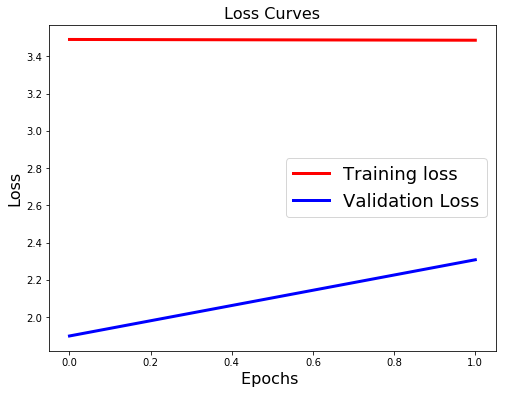

------ Accuracy graphs -------


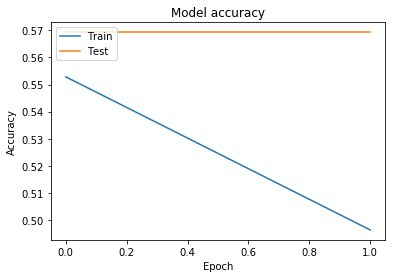

In [96]:
print_loss_graphs(hist.history)

In [85]:
score = model.evaluate(x_test, y_test, verbose=0)


In [86]:
score

[4.185404138322212, 0.5692930221557617]